<a href="https://colab.research.google.com/github/Ox03bb/Digits_Recognition/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240711%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240711T234709Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D13decdca4b7a855624b1c6d94c021b67ff1b1bf32a8e7c26686a2397487193bb3c4eb4fa4c04ce8901e5b9f10039b88bb2b95b85a6889fba28fd4cdfb51d64eace12cee621bc74e3b87d46d558d634ad29098ce71e2631d31640e0a57132334166345e3ab71e6b5a3f9d87b6982994b31fbe3f2fd9ca3cb55540ec935d1b0edc6c0afa7558f1776cd848e29239e4b30b640ce0e1ec15dce16780d953d1b073266d24761c35804c6c75e671e20b5790ca3e1e8fe216ed4df26744b9b478446fe6b8567f6ea786424b34255c08f7d224781fbbdf5907cacf84bea0698107c68df14813ccb3eb5a7895a871bffb07673ef785bf2405764d17e7473b6cfdbc3886e8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


# I- Packages :

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns


import tensorflow as tf

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Resizing,Reshape,Dropout

from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.models import Sequential

from tensorflow.keras.datasets import mnist


from sklearn.model_selection import GridSearchCV

from IPython.display import clear_output

# II- Data:

In [144]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train.reshape(-1,28,28,1).astype('float32') / 255.0
x_test = x_test.reshape(-1,28,28,1).astype('float32') / 255.0

In [145]:
print("x_train : ",x_train.shape)
print("x_train[0]: ",x_train[0].shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)

x_train :  (60000, 28, 28, 1)
x_train[0]:  (28, 28, 1)
y_train :  (60000,)
y_test :  (10000,)


In [146]:
y_train = tf.keras.utils.to_categorical(y_train,10 )
y_test = tf.keras.utils.to_categorical(y_test,10 )

print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)

print("y_train : ",y_train[0])


y_train :  (60000, 10)
y_test :  (10000, 10)
y_train :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


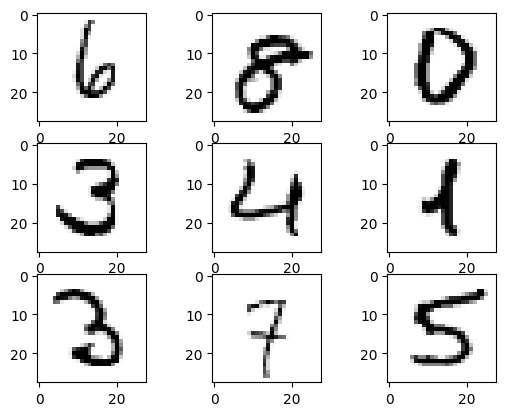

In [125]:
fig, ax = plt.subplots(nrows=3, ncols=3)
cnt = 0
for i in range(0,3):
    for j in range(0,3):
        ax[i,j].imshow(x_train[np.random.randint(0, 60000)].reshape(28,28),cmap='Greys')

# III- VGG-16

In [126]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_base.trainable = False
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [147]:
class GrayscaleToRGB(Layer):
    def __init__(self, **kwargs):
        super(GrayscaleToRGB, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

In [152]:

model = Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    Resizing(width=32, height=32),
    GrayscaleToRGB(),
    vgg_base,
    Flatten(),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(10, activation='Softmax')
])

In [153]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_15 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 grayscale_to_rgb_15 (Grays  (None, 32, 32, 3)         0         
 caleToRGB)                                                      
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_15 (Flatten)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 10)                5130      
                                                                 
Total params: 14719818 (56.15 MB)
Trainable params: 5130 (20.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [154]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [173]:
early_stopping = EarlyStopping(monitor='accuracy',min_delta=0.3, patience=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/3
1875/1875 [==============================] - 924s 493ms/step - loss: 0.2994 - accuracy: 0.9211 - val_loss: 0.2435 - val_accuracy: 0.9369
Epoch 2/3
1875/1875 [==============================] - 930s 496ms/step - loss: 0.2313 - accuracy: 0.9381 - val_loss: 0.1987 - val_accuracy: 0.9464


In [174]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.2993886470794678, 0.23128467798233032]
[0.9211166501045227, 0.9380833506584167]
[0.24352888762950897, 0.19873583316802979]
[0.9369000196456909, 0.946399986743927]


In [193]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print("val_loss: ", val_loss)
print("val_accuracy: ", val_accuracy)

313/313 [==============================] - 130s 414ms/step - loss: 0.2435 - accuracy: 0.9369
val_loss:  0.24352888762950897
val_accuracy:  0.9369000196456909


> this model is too slow on trainig, but offer a hight accuracy

# IV- InceptionV3

In [177]:
ins3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
ins3.trainable = False
ins3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 37, 37, 32)           864       ['input_28[0][0]']            
                                                                                                  
 batch_normalization_188 (B  (None, 37, 37, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 37, 37, 32)           0         ['batch_normalizati

In [182]:

model_ins3 = Sequential([
    tf.keras.Input(shape=(28, 28, 1)),
    Resizing(width=75, height=75),
    GrayscaleToRGB(),
    ins3,
    Flatten(),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(10, activation='Softmax')
])

In [184]:
model_ins3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_17 (Resizing)      (None, 75, 75, 1)         0         
                                                                 
 grayscale_to_rgb_17 (Grays  (None, 75, 75, 3)         0         
 caleToRGB)                                                      
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_17 (Flatten)        (None, 2048)              0         
                                                                 
 dense_31 (Dense)            (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 21802784 (83.17 MB)
________

In [185]:
model_ins3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [187]:
early_stopping = EarlyStopping(monitor='accuracy',min_delta=0.01, patience=3, restore_best_weights=True)

history_2 = model_ins3.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test), callbacks=[early_stopping])

1875/1875 [==============================] - 713s 380ms/step - loss: 0.2273 - accuracy: 0.9280 - val_loss: 0.2202 - val_accuracy: 0.9316


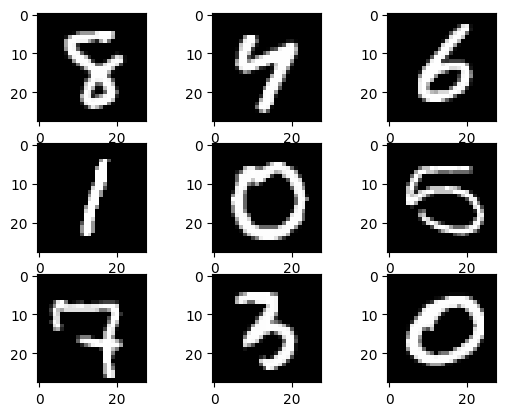

In [190]:
fig, ax = plt.subplots(nrows=3, ncols=3)
cnt = 0
for i in range(0,3):
    for j in range(0,3):
        ax[i,j].imshow(1-x_train[np.random.randint(0, 60000)].reshape(28,28),cmap='Greys')

In [191]:
x_inv = 1-x_train

In [192]:
history_3 = model_ins3.fit(x_inv, y_train, epochs=1, validation_data=(x_test, y_test), callbacks=[early_stopping])

1875/1875 [==============================] - 685s 365ms/step - loss: 0.3389 - accuracy: 0.8931 - val_loss: 0.7623 - val_accuracy: 0.7514


In [194]:
val_loss, val_accuracy = model_ins3.evaluate(x_test, y_test)
print("val_loss: ", val_loss)
print("val_accuracy: ", val_accuracy)

313/313 [==============================] - 96s 307ms/step - loss: 0.7623 - accuracy: 0.7514
val_loss:  0.7622536420822144
val_accuracy:  0.7513999938964844


In [195]:
x_all = np.concatenate((x_train, x_inv))
y_all = np.concatenate((y_train, y_train))

(120000, 28, 28, 1)